# Analysetechniken fuer grosse Datenbestaende - Qualification Task
by Lukas Bach

## Preparing data

In [155]:
import pandas as pd
import plotly.offline as py
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

testData = pd.read_csv("./DMC_2019_task/test.csv", delimiter='|')
trainData = pd.read_csv("./DMC_2019_task/train.csv", delimiter='|')
solutionData = pd.read_csv("./DMC_2019_task/solution.csv", delimiter='|')

print(trainData.shape)

(1879, 10)


In [156]:
trainData.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


Lets get a quick overview over the columns available.

In [157]:
y = trainData[["fraud"]].values.ravel()
print('Rows with fraud=0: ' + str(np.count_nonzero(y)) + '/' + str(len(y)))

for col in trainData.columns:
    print(' - ' + col)

Rows with fraud=0: 104/1879
 - trustLevel
 - totalScanTimeInSeconds
 - grandTotal
 - lineItemVoids
 - scansWithoutRegistration
 - quantityModifications
 - scannedLineItemsPerSecond
 - valuePerSecond
 - lineItemVoidsPerPosition
 - fraud


In [158]:
trainData.describe()


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,3.401809,932.153273,50.864492,5.469931,4.904204,2.525279,0.058138,0.201746,0.745404,0.055349
std,1.709404,530.144640,28.940202,3.451169,3.139697,1.695472,0.278512,1.242135,1.327241,0.228720
min,1.000000,2.000000,0.010000,0.000000,0.000000,0.000000,0.000548,0.000007,0.000000,0.000000
25%,2.000000,474.500000,25.965000,2.000000,2.000000,1.000000,0.008384,0.027787,0.160000,0.000000
50%,3.000000,932.000000,51.210000,5.000000,5.000000,3.000000,0.016317,0.054498,0.350000,0.000000
75%,5.000000,1397.000000,77.285000,8.000000,8.000000,4.000000,0.032594,0.107313,0.666667,0.000000
max,6.000000,1831.000000,99.960000,11.000000,10.000000,5.000000,6.666667,37.870000,11.000000,1.000000


Apart from the unbalance of the data, i.e. almost no rows with fraud=0 compared to
other rows, the data is fairly well organized. All cells are filled and contain
float numbers.

Lets visualize the data.

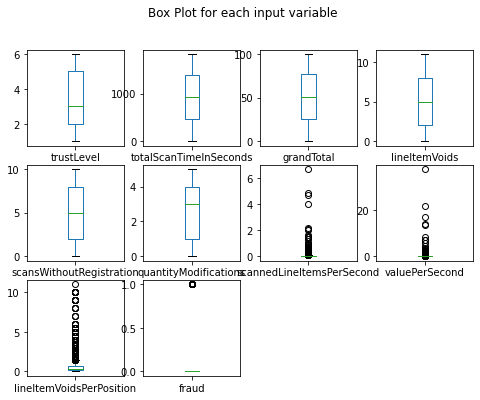

In [159]:
trainData.plot(kind='box', subplots=True,
          layout=(3,4), sharex=False,
          sharey=False, figsize=(8,6),
          title='Box Plot for each input variable')
plt.savefig('data_box')
plt.show()

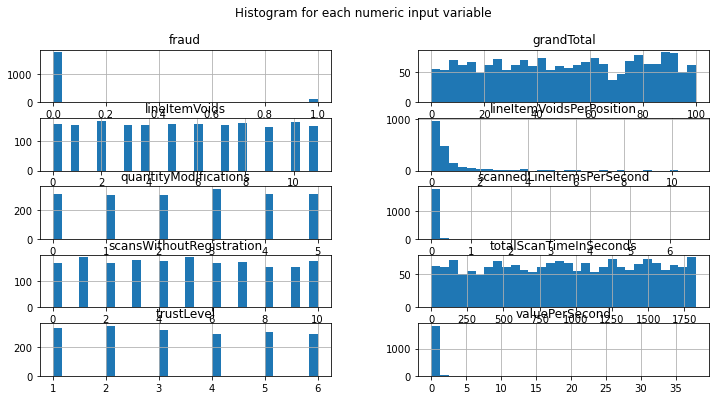

In [160]:
import pylab as pl
trainData.hist(bins=30, figsize=(12, 6), layout=(5,2))
pl.suptitle("Histogram for each numeric input variable")
plt.savefig('data_hist')
plt.show()

Lets prepare the data for training. Again, no actual tidy-up required, just
horizontally split data into X-sourcedata and a y-row which contains the train-
input (fraud row). We will not split the data into train- and verification-data
as we can use the supplied test.csv and solution.csv for verification, so we will
use the train.csv data entirely for training.

In [161]:
X = trainData.drop('fraud', axis=1)
y = trainData[["fraud"]].values.ravel()
print('Nonzero values: ' + str(np.count_nonzero(y)) + '/' + str(len(y)))


Nonzero values: 104/1879


## Defining custom functions

### Custom score function

The task defines a custom score function, that I have defined here. I've used
it later to calculate the monetary result from classifiers. The scorer object
returned from ``skm`` can be used in some ml trainers, but the classifiers I
have used unfortunately did not support custom score functions.

In [162]:
import sklearn.metrics as skm

def customScoreFunction(actualY, predictedY):
    if actualY == 1:
        if predictedY == 1:
            return 5
        elif predictedY == 0:
            return -5
    elif actualY == 0:
        if predictedY == 1:
            return -25
        elif predictedY == 0:
            return 0
scorer = skm.make_scorer(customScoreFunction, greater_is_better=True)

### Prediction checker
The following utility method calculates and logs tp, fp, tn, fn, the calculated
monetary result as well as accuracy, precision and f1 value.

In [163]:
import sklearn.metrics as skm

def checkPrediction(name, prediction):
    print("Prediction of " + name)
    fp, fn, tp, tn = 0, 0, 0, 0
    for i in range(len(solutionData) - 2):
        rowSolution = solutionData.get("fraud")[i]
        rowPrediction = prediction[i]

        if rowSolution == 1:
            if rowPrediction == 1:
                tp += 1
            elif rowPrediction == 0:
                fn += 1
        elif rowSolution == 0:
            if rowPrediction == 1:
                fp += 1
            elif rowPrediction == 0:
                tn += 1

    print("True Positives: " + str(tp))
    print("True Negatives: " + str(tn))
    print("False Positives: " + str(fp))
    print("False Negatives: " + str(fn))

    win = fn * (-5) + fp * (-25) + tp * 5

    print("Monetary result: " + str(win))

    print("Accuracy: " + str(skm.accuracy_score(solutionData.get("fraud"), prediction)))
    print("Precision: " + str(skm.precision_score(solutionData.get("fraud"), prediction)))
    print("F1: " + str(skm.f1_score(solutionData.get("fraud"), prediction)))

## Attempts for improving data quality
In an effort to counter the data imbalance issue, I used SMOTE oversampling.
I have tried values for ``k_neighbors`` larger than one, but that seemed to have
hurt classification quality, so I used a value of one, which I suppose yields
results similar to normal oversampling.

In [164]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, k_neighbors=1)
XOverSampled, yOversampled = sm.fit_sample(X, y)

print('Previously Nonzero values: ' + str(np.count_nonzero(y)) + '/' + str(len(y)))
print('Now Nonzero values: ' + str(np.count_nonzero(yOversampled)) + '/' + str(len(yOversampled)))

Previously Nonzero values: 104/1879
Now Nonzero values: 1775/3550


I've also attempted a dimensionality reduction, however again as shown later,
that did not yield good results.

In [165]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X, y)
XPca = pca.transform(XOverSampled)
testdataPca = pca.transform(testData)
print(XPca.shape)



(3550, 5)


## Classification
For some reason, I've yielded the best results using a random forest classifier
both without oversampling and PCA. The precision is still not good enough, and the
resulting score with the custom score function is still bad.

In [166]:
RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
RF.fit(X, y)
prediction = RF.predict(testData)
print("Score: " + str(RF.score(X, y)))
checkPrediction("Random Forest Classifier without oversampling", prediction)

Score: 1.0
Prediction of Random Forest Classifier without oversampling
True Positives: 14357
True Negatives: 470759
False Positives: 3633
False Negatives: 9370
Monetary result: -65890
Accuracy: 0.9738959007951883
Precision: 0.7980544747081713
F1: 0.6883045281300191


Lets output the result to a csv file.

In [167]:
pd.DataFrame(prediction, columns=['fraud']).to_csv('prediction.csv', index=None)

## All Classification attempts

### Random Forest Classifier, no oversampling, no PCA

In [168]:
RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
RF.fit(X, y)
prediction = RF.predict(testData)
print("Score: " + str(RF.score(X, y)))
checkPrediction("Random Forest Classifier without oversampling", prediction)

Score: 1.0
Prediction of Random Forest Classifier without oversampling
True Positives: 14357
True Negatives: 470759
False Positives: 3633
False Negatives: 9370
Monetary result: -65890
Accuracy: 0.9738959007951883
Precision: 0.7980544747081713
F1: 0.6883045281300191


### Random Forest Classifier, oversampling, no PCA

In [169]:
RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
RF.fit(XOverSampled, yOversampled)
prediction = RF.predict(testData)
print("Score: " + str(RF.score(XOverSampled, yOversampled)))
checkPrediction("Random Forest Classifier with oversampling", prediction)

Score: 0.991830985915493
Prediction of Random Forest Classifier with oversampling
True Positives: 17022
True Negatives: 460746
False Positives: 13646
False Negatives: 6705
Monetary result: -289565
Accuracy: 0.9591444648990908
Precision: 0.55504108517021
F1: 0.6258663480099274


### Random Forest Classifier, oversampling, PCA
As the results show, PCA does not positively affect performance.

In [170]:
RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
RF.fit(XPca, yOversampled)
prediction = RF.predict(testdataPca)
checkPrediction("Random Forest Classifier with everything", prediction)

Prediction of Random Forest Classifier with everything
True Positives: 12850
True Negatives: 429042
False Positives: 45350
False Negatives: 10877
Monetary result: -1123885
Accuracy: 0.8871218037384491
Precision: 0.22079037800687284
F1: 0.31369389822646987


### SGDClassifier, oversampling, no PCA

In [171]:
from sklearn.linear_model import SGDClassifier

SGD = SGDClassifier(loss="log")
SGD.fit(XPca, yOversampled)
prediction = SGD.predict(testdataPca)
checkPrediction("SGDClassifier with oversampling", prediction)

Prediction of SGDClassifier with oversampling
True Positives: 16952
True Negatives: 294684
False Positives: 179708
False Negatives: 6775
Monetary result: -4441815
Accuracy: 0.6256230915781507
Precision: 0.08619865556131841
F1: 0.15383707898307084
